# Approach

In this assignment, I used the seq2seq model with attention (usually used for machine translation) to get harmonize the melody line. I assumed that the highest pitch played at any one moment is the melody (as it is often true in vocal music — which is what I used as my training data — that the soprano/highest voice sings the melody). Therefore, each input is comprised of 5 notes in the melody and the output is all the other notes played at the same time (the harmony). Each note in the input is represented as a stringified midi pitch (so a number representing the pitch) and the output is represented as a stringified one-hot-encoding of notes present in the harmony. To be clear, the notes incorporate octave information as well (if not it would be trivial to map from a melody note to harmony notes, given that the harmony notes are just notes in the same chord). By including octave information, the seq2seq model has to learn which direction the harmony moves in as well (or the bass notes for the harmony etc.)

Example input: 67 67 67 67 67 	

Example output: 000000000000000000000100000000000000010010000100000000000000000000000000000000000000000 000000000000000000000100000000000000010010000100000000000000000000000000000000000000000 000000000000000000000100000000000000010010000100000000000000000000000000000000000000000 000000000000000000000100000000000000010010000100000000000000000000000000000000000000000 000000000000000000000000000000000100010010000100000000000000000000000000000000000000000 

For the model code, I reused code from [this tutorial](https://kern.humdrum.org/cgi-bin/ksbrowse?type=collection&l=/users/craig/classical/bach/371chorales) by Robertson (n.d.). The code was originally used for machine translation, so I just preprocessed my input data to fit the input required by the machine translation code. I comment on any modifications I made, as well as on the architecture of the model in the cells.

Although at first glance, music generation might seem a bad candidate for using seq2seq because seq2seq lacks the diversity of outputs produced by some other RNN models (it tries to maximise the probability of the prediction), I think it is appropriate for harmonization because of the limited scope of possible outputs i.e. we are not trying to "generate" a new melody, we are trying to translate a melody into its harmony. 

# Data

I used 50 chorales written by Bach as my input data (though each chorale was split up into one-shifted sequences of 5 yielding 121120 input-output pairs). The chorales contain four voices, and I used the highest voice as input data, whist using the other voices as output data. [Link to dataset](https://kern.humdrum.org/cgi-bin/ksbrowse?type=collection&l=/users/craig/classical/bach/371chorales). 

# Architecture of Seq2Seq

I used a seq2seq model, which is composed of two recurrent neural networks i.e. an encoder and a decoder. The encoder takes the input sequence (here a sequence of midi pitch notes) and produces an embedding for it. This embedding is taken as input to the decoder which tries to predict the output sequence, also using information from the previous output word. 

<img src="https://drive.google.com/uc?export=view&id=1ZthW4u9gsG7yAPdv355W1l9N1VR7PLi-" style="width:700px;">

image source: [Generative-Model-Chatbots](https://medium.com/botsupply/generative-model-chatbots-e422ab08461e)


# Results
I ran the model for 300000 iterations (which took about 2 hours on the Colab GPU). 

The audio results (recorded at every 5000th iteration) can be found in this folder: [Folder](https://drive.google.com/drive/folders/1F9ejRX1aQrG5_wsp8jL-Ow6ZJZJRh_LF?usp=sharing). See loss below.

<img src="https://drive.google.com/uc?export=view&id=1t6wJJL9m8NuNOHGJI2egXVFAZnFtrLDA" style="width:500px;">

# Interpretation of results

A good sign is that we do not have generated samples that also appeared in the training samples (i.e. we do not have the same sequence of harmonies appearing in the input, which means our model is not just memorizing training data). [Note: I think that my code which checks for this working fine, but I personally find this statement hard to believe, because it seems unlikely that there are not more repetitions in a 5-note sequence output set, especially as we are using a translation model, and not a model that incorporates more randomness/ is trained for diversity].

Comparing samples from the 5000th iteration and the 300000th iteration, we can hear that the 5000th iteration model already produces consonant harmonies. However, the main thing I noticed is that the model from the 295000th epoch in contrast, is sophisticated enough to play more complicated chords rather than only easier chords (using the first, third and fifth notes on a musical scale for example). An example of sophistication is when it experimented with a A#7 chord in 300000_17.wav as well as G#m6 in 300000_23.wav

As a sanity check, I tried the model on 5 randomly chosen sequences from 5 chorales that were not in the training data, to see if reasonable results were produced. You can listen to the results here, but they are indeed quite reasonable: [Folder](https://drive.google.com/open?id=1ubm9lZfkEH9d7sDOvK9b3-vkuIouifwI)

I suppose one weakness of this paper is that I do not quantitatively evaluate the results using something like an augmented BLEU score.

Furthermore, it is a little hard to tell if generated samples indicate mode collapse, because there are a quantifiable number of transitions that might be made from one time step to another without causing dissonance.

# References

Robertson, S. (n.d.). NLP from Scratch: Translation with a Sequence-to-Sequence Network and Attention. Retrieved from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

cpmpercussion(2019), creative-prediction,  https://github.com/cpmpercussion/creative-prediction/blob/master/notebooks/3-zeldic-musical-RNN.ipynb






In [0]:
%matplotlib inline

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive')
#mounting Google Drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#preprocess data
# I modified the function streamToNoteArray from this repo: \
#https://github.com/cpmpercussion/creative-prediction/blob/master/\
#notebooks/3-zeldic-musical-RNN.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from music21 import converter, instrument, note, chord, stream, midi


MELODY_NOTE_OFF = 128 # (stop playing all previous notes)
MELODY_NO_EVENT = 129 # (no change from previous event)
# process the ties

#use function to stream the data from midi file (already converted 
#to music21) 
#to an array of notes
def streamToNoteArray(stream):
    # Part one, extract from stream
    total_length = np.int(np.round(stream.flat.highestTime / 0.25))
     # in semiquavers
    stream_list = []
    for element in stream.flat:
        if isinstance(element, note.Note):
            stream_list.append([np.round(element.offset / 0.25), \
                                np.round(element.quarterLength / 0.25)\
                                , element.pitch.midi])
        elif isinstance(element, chord.Chord):
            stream_list.append([np.round(element.offset / 0.25), \
                                np.round(element.quarterLength / 0.25),\
                                element.sortAscending().pitches[-1].midi])
    np_stream_list = np.array(stream_list, dtype=np.int)
    return(np_stream_list)

#
songs = []
for i in range(1, 51):
  if len(str(i))==1:
    e = "00" + str(i)
  elif len(str(i))==2:
    e = "0" + str(i)
  else:
    e = str(i)
  song = converter.parse('bach/chor{}.midi'.format(e))
  songs.append(streamToNoteArray(song))

#make the data into a dataframe
columns = ["id", "st", "dur", "pitch"]
df = pd.DataFrame(columns = columns)
df
for i in range(len(songs)):
  for e in range(len(songs[i])):
    df = df.append({"id":i, "st":songs[i][e][0], "dur":songs[i][e][1],\
                    "pitch":songs[i][e][2]}, ignore_index = True)
d = df

#make a new dataframe that has a row for each time step where
# notes play
col_dur = ["id"] + ["timestep"] + ["soprano"] + [str(i) for \
                                                 i in range(22, \
                                                            109)]
duration_df = pd.DataFrame(columns = col_dur)

#so I know when a note is no longer played
d["end"] = d["st"].add(d["dur"])

for i in range(len(d["id"].unique())):
  for time in range(max(d[d["id"] == d["id"].unique()[i]]["end"])):
    # print(time)
    rows = d[d["id"]==d["id"].unique()[i]][(d[d["id"]==d["id"].\
                                              unique()[i]]["st"]\
                                            <=time) &  (d[d["id"]==\
                                                          d["id"].unique\
                                                          ()[i]]["end"]>\
                                                        time)]
    if rows.empty==False:
      soprano = max(rows["pitch"])
      dict_to_add_row = {"id": d["id"].unique()[i], "timestep":\
                         time, "soprano":soprano}
      for k in range(22, 109):
        dict_to_add_row[str(k)] = 0
      for note in rows["pitch"]:
        dict_to_add_row[str(note)]=1
      duration_df = duration_df.append(dict_to_add_row, \
                                       ignore_index = True)


data = duration_df

data_inputs = []
data_outputs = []
for i in data.iloc[:,0].unique():
  for e in range(len(data[data.iloc[:,0]==i])):
    b = list(data[data.iloc[:,0]==i].iloc[:,2][e:e+5])
    c = ""
    for j in range(len(b)):
      c = c + str(b[j])+ " "
    data_inputs.append(c)
    data_outputs.append(data[data.iloc[:,0]==i].iloc[:,3:90].\
                        iloc[e:e+5])

all_output_seq = []
for sequence in range(len(data_outputs)):
  curr_seq = ""
  for i in range(len(data_outputs[sequence])):
    curr_seq = curr_seq + "".join([str(s) for s in list(data_outputs\
                                                        [sequence].\
                                                        iloc[i])])
    curr_seq = curr_seq+" "
  all_output_seq.append(curr_seq)

#write to text file in input-output tab separated format for input\
 into seq2seq
file = open("data/bass-harmony.txt", "w")
for i in range(len(data_inputs)):
  file.write(data_inputs[i] + "\t" + all_output_seq[i])
  file.write("\n")


In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
# !pip install music21
import music21

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
SOS_token = 0
EOS_token = 1

#maps from notes/chords to index
#similar to mapping words in a vocab to index
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [0]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs
    pairs = [[s for s in l.split('\t')] for l in lines] 
    #i do not normalize strings like tutorial, unnecessary
    #for my application

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [0]:
MAX_LENGTH = 10

def filterPair(p):
    return True

#i do not do any filtering
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [0]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2,\
                                               reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('bass', \
                                             'harmony', False)
print(random.choice(pairs))

Reading lines...
Read 12212 sentence pairs
Trimmed to 12212 sentence pairs
Counting words...
Counted words:
bass 24
harmony 1571
['71 69 69 67 67 ', '000000000000000000000000000000000100010000000000010000000000000000000000000000000000000 000000000000000000000000000000001001000100000001000000000000000000000000000000000000000 000000000000000000000000000000001001000100000001000000000000000000000000000000000000000 000000000000000000000000000010000000010010000100000000000000000000000000000000000000000 000000000000000000000000000010000000010010000100000000000000000000000000000000000000000 ']


In [0]:
#defining encoder with a hidden layer, an embedding layer
# and a gru layer
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
#basic decoder to map from output of encoder to prediction
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
#decoder but with attention, notice the extra
#linear and dropout layers
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1,\
                 max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [0]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, \
                        device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

#just to convert training pairs to tensors

In [0]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,\
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, \
                                  encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < \
    teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  
            # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [0]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [0]:
#wrote this code to generate outputted predictions
#and then convert to abc so we can listen to it
pitches = list(range(22, 109))

notes = []
for oct_ in range(9):
  notes_beg = ["A{}".format(oct_), "^A{}".format(oct_), \
               "B{}".format(oct_), "C{}".format(oct_+1), \
               "^C{}".format(oct_+1), "D{}".format(oct_+1),\
               "^D{}".format(oct_+1), "E{}".format(oct_+1), \
               "F{}".format(oct_+1), "^F".format(oct_+1), \
               "G{}".format(oct_+1), "^G{}".format(oct_+1)]
  notes.extend(notes_beg)
notes = notes[:87]
note_index = dict(zip(pitches, notes))
inv_note_index = {v: k for k, v in note_index.items()}

import re
def convert_bin_to_chord(binary):
  output = []
  list_ = binary.split(" ")
  n_output_words = []
  for i in list_:
    if i!="" and i!="<EOS>":
      n_output_words.append(i)
  output_words = n_output_words
  for i in range(len(output_words)):
    c = []
    for e in re.finditer("1", output_words[i]):
      c.append(e.start() + 22)
    c = sorted(c)
    chord = [note_index[int(n)] for n in c]
    output.append("".join(chord))
  return output

#this name is a little misleading bc we are converting to abc, 
#not midi yet
def convert_to_midi(encoder, decoder, random_=1, pair = []):
        if random_==1:
          pair = random.choice(pairs)
          notes_in_ori = pair[1]
          output_words, attentions = evaluate(encoder, decoder, pair[0])
          output_sentence = ' '.join(output_words)
          output= convert_bin_to_chord(output_sentence)
          true_out = convert_bin_to_chord(notes_in_ori)
          if output_sentence[:-5] not in [i[1] for i in pairs]:
            print("not a duplicate!")
          return output, true_out
        else:
          pair = pair
          notes_in_ori = pair[1]
          output_words, attentions = evaluate(encoder, decoder, pair[0])
          output_sentence = ' '.join(output_words)
          output= convert_bin_to_chord(output_sentence)
          true_out = convert_bin_to_chord(notes_in_ori)
          if output_sentence[:-5] not in [i[1] for i in pairs]:
            print("not a duplicate!")
          return output, true_out




In [0]:

def trainIters(encoder, decoder, n_iters, print_every=1000, \
               plot_every=100, learning_rate=0.01, i_start = 0):
    start = time.time()
    print_loss_total = 0  # Reset every print_every
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.CrossEntropyLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss

        if iter % print_every == 0:
            torch.save(encoder.state_dict(), "enc_bass_harm")
            torch.save(decoder.state_dict(), "dec_bass_harm")
            with open("output{}.txt".format(iter+i_start), "w") as file:
              for y in range(5):
                out_abc, true = convert_to_midi(encoder, decoder)
                file.write(str(y))
                file.write("\n")
                for e in out_abc:
                  file.write(e)
                  file.write("\n")

            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100,\
                                         print_loss_avg))
            if iter+i_start!=1:
              with open("loss.txt", "a+") as file:
                file.write(str(print_loss_avg))
                file.write("\n")
            else:
              with open("loss.txt", "w") as file:
                file.write(str(print_loss_avg))
                file.write("\n")

            #i write loss to file instead of directly plotting
            #i also save the latest model to file and 5 samples every 
            #5000 iters

In [0]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, \
                                      encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [0]:
# hidden_size = 256
# encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, \
#dropout_p=0.1).to(device)
trainIters(encoder1, attn_decoder1, 150000, \
           print_every=5000, i_start = 150000)

#if we comment out the first three lines, we can continue training
#after stopping

not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
2m 7s (- 61m 42s) (5000 3%) 1.8801
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
4m 0s (- 56m 12s) (10000 6%) 1.8666
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
5m 55s (- 53m 18s) (15000 10%) 1.8705
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
7m 50s (- 50m 55s) (20000 13%) 1.8498
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
9m 42s (- 48m 32s) (25000 16%) 1.8187
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
11m 36s (- 46m 27s) (30000 20%) 1.8386
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
13m 31s (- 44m 26s) (35000 23%) 1.8496
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
not a duplicate!
15m 28s (- 42m 34s) (40000 26%) 1.8160
not a duplicate!
n

In [0]:
#i commented it out bc it produces lots of text
#saying things the midi is being rendered to wav

# !apt install fluidsynth
# !cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
# import re
# import music21
# #convert to midi then to wav for easy listening

# i_start = 150000 #change this to latest iter for start training
# for i in list(range(0, 150001))[::5000]:
#   print("iter: ", i+i_start)
#   out_abc = []
#   file = open("output{}.txt".format(i+i_start), "r")
#   for en, e in enumerate(file.readlines()[1:]):
#     if re.match("[0-9]+", e)==None:
#       out_abc.append(e[:-1])
#     else:
#       print(out_abc)
#       #play
#       if len(out_abc)==5:
#         abcStr = ('M:5/4\nL:1/8\nK:C\nV:1 name="Whistle" ' +
#             'snm="wh"\n[{}] [{}] [{}] [{}] [{}] ||\nV:2 name="piano" '.\
#             format(out_abc[0], out_abc[1], out_abc[2], out_abc[3],out_abc[4]))
#       elif len(out_abc)==4:
#           abcStr = ('M:4/4\nL:1/8\nK:C\nV:1 name="Whistle" ' +
#             'snm="wh"\n[{}] [{}] [{}] [{}]||\nV:2 name="piano" '.\
#             format(out_abc[0], out_abc[1], out_abc[2], out_abc[3]))
#       elif len(out_abc)==3:
#           abcStr = ('M:3/4\nL:1/8\nK:C\nV:1 name="Whistle" ' +
#             'snm="wh"\n[{}] [{}] [{}]||\nV:2 name="piano" '.format\
#             (out_abc[0], out_abc[1], out_abc[2]))
#       elif len(out_abc)==2:
#           abcStr = ('M:2/4\nL:1/8\nK:C\nV:1 name="Whistle" ' +
#             'snm="wh"\n[{}] [{}]||\nV:2 name="piano" '.format\
#             (out_abc[0], out_abc[1]))
#       elif len(out_abc)==1:
#           abcStr = ('M:4/4\nL:1/8\nK:C\nV:1 name="Whistle" ' +
#             'snm="wh"\n[{}] ||\nV:2 name="piano" '.format\
#             (out_abc[0]))
#       out = music21.converter.parse(abcStr).write("midi")
#       ie = str(i)
#       o = 'bach_out/{}_{}.wav'.format(i+i_start, en)
#       !fluidsynth -ni font.sf2 $out -F $o -r 44100
#       from IPython.display import Audio
#       Audio('bach_out/{}_{}.wav'.format(i+i_start, en))
#       #reset for next sample
#       out_abc = []
    
  

#   #generate
#   # out_abc, true = convert_to_midi(encoder1, attn_decoder1)

  

Text(0, 0.5, 'avg_loss/5000 iters')

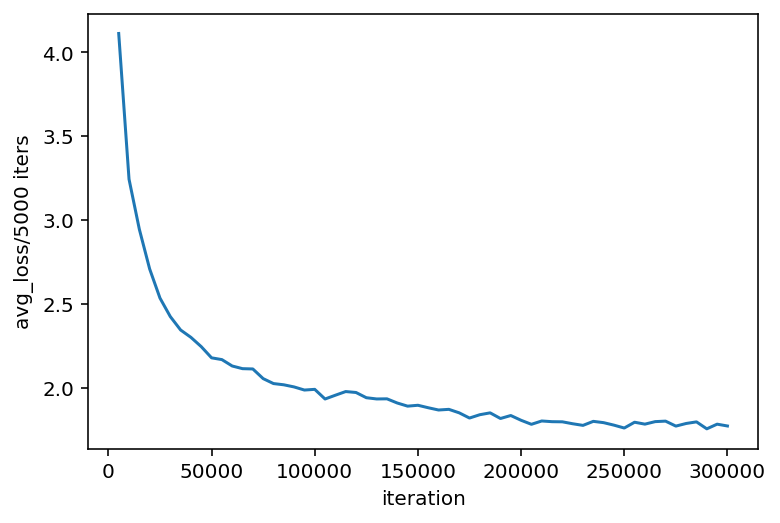

In [0]:
#plot loss

import matplotlib.pyplot as plt
losses = []
with open("loss.txt", "r") as file:
  for e in file.readlines():
    losses.append(float(e[:-1]))

plt.plot(list(range(5000, 300001))[::5000], losses)
plt.xlabel("iteration")
plt.ylabel("avg_loss/5000 iters")

In [0]:
# #code to reload saved model & test on test set
#i commented it out bc it produces lots of text
#saying things the midi is being rendered to wav
# !apt install fluidsynth
# !cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2
# inp = ['74 72 72 72 72 ', '69 69 69 69 69 ', '67 67 67 72 72 ',\
#        '73 71 71 71 71 ', '67 67 67 67 67 ']
# outp = ['000000000000000000000000000000001000000000100000100100000000000000000000000000000000000 000000000000000000000000010000000000000001001000010000000000000000000000000000000000000 000000000000000000000000010000000000000001001000010000000000000000000000000000000000000 000000000000000000000000010000000000000001001000010000000000000000000000000000000000000 000000000000000000000000010000000000000001001000010000000000000000000000000000000000000 ', '000000000000000000000000010000000000000010000010010000000000000000000000000000000000000 000000000000000000000000010000000000000010000010010000000000000000000000000000000000000 000000000000000000000000010000000000000010001000010000000000000000000000000000000000000 000000000000000000000000010000000000000010001000010000000000000000000000000000000000000 000000000000000000010000000000000000000100000010000100000000000000000000000000000000000 ', '000000000000000000000000000000000001000010000000010010000000000000000000000000000000000 000000000000000000000000000000000001000010000000010010000000000000000000000000000000000 000000000000000000000000000000000000100100000000000100100000000000000000000000000000000 000000000000000000000000000000000000100100000000000100100000000000000000000000000000000 000000000000000000000000000000000000100000001000000100100000000000000000000000000000000 ', '000000000000000000000000100000000000000010010000100000000000000000000000000000000000000 000000000000000000000000100000000000000010010000100000000000000000000000000000000000000 000000000000000000000000100000000000000010010000100000000000000000000000000000000000000 000000000000000000000000100000000000000010010000100000000000000000000000000000000000000 000000000000000000000000100000000000000010010000100000000000000000000000000000000000000 ', '000000000000000000000000000000001001000010000001000000000000000000000000000000000000000 000000000000000000000000000000001001000010000001000000000000000000000000000000000000000 000000000000000000000000000000000100010010000001000000000000000000000000000000000000000 000000000000000000000000000000000100010010000001000000000000000000000000000000000000000 000000000000000000000000000000000001000100000001000000000000000000000000000000000000000 ']

# #i did the preprocessing for the test set similar to the training set 
# for i in range(len(inp)):
#   hidden_size = 256
#   encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
#   decoder2 = AttnDecoderRNN(hidden_size, 1547, dropout_p\
#                             =0.1).to(device)

#   encoder2.load_state_dict(torch.load("enc_bass_harm"))
#   decoder2.load_state_dict(torch.load("dec_bass_harm"))

#   out_abc, true = convert_to_midi(encoder2, decoder2, 0, (inp[i], outp[i]))
#   if len(out_abc)==5:
#     abcStr = ('M:5/4\nL:1/8\nK:C\nV:1 name="Whistle" ' +
#         'snm="wh"\n[{}] [{}] [{}] [{}] [{}] ||\nV:2 name="piano" '.format\
#         (out_abc[0], out_abc[1], out_abc[2], out_abc[3],out_abc[4]))
#   elif len(out_abc)==4:
#       abcStr = ('M:4/4\nL:1/8\nK:C\nV:1 name="Whistle" ' +
#         'snm="wh"\n[{}] [{}] [{}] [{}]||\nV:2 name="piano" '.format\
#         (out_abc[0], out_abc[1], out_abc[2], out_abc[3]))
#   elif len(out_abc)==3:
#       abcStr = ('M:3/4\nL:1/8\nK:C\nV:1 name="Whistle" ' +
#         'snm="wh"\n[{}] [{}] [{}]||\nV:2 name="piano" '.format\
#         (out_abc[0], out_abc[1], out_abc[2]))
#   elif len(out_abc)==2:
#       abcStr = ('M:2/4\nL:1/8\nK:C\nV:1 name="Whistle" ' +
#         'snm="wh"\n[{}] [{}]||\nV:2 name="piano" '.format\
#         (out_abc[0], out_abc[1]))
#   elif len(out_abc)==1:
#       abcStr = ('M:4/4\nL:1/8\nK:C\nV:1 name="Whistle" ' +
#         'snm="wh"\n[{}] ||\nV:2 name="piano" '.format(out_abc[0]))
#   out = music21.converter.parse(abcStr).write("midi")
#   ie = str(i)
#   o = 'bach_out/test_5/{}.wav'.format(i)
#   !fluidsynth -ni font.sf2 $out -F $o -r 44100
#   from IPython.display import Audio
#   Audio('bach_out/test_5/{}.wav'.format(i))


